In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor


from sklearn.linear_model import LinearRegression



In [109]:
plt.style.use('ggplot')

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"


Make some functions to Generate Simulated Data

In [15]:
function_list = [
    lambda x: -2 * (x < -3) + 2.55 * (x > -2) - 2 * (x > 0) + 4 * (x > 2) - 1 * (x > 3),
    lambda x: 6 + 0.4 * x - 0.36 * x**2 + 0.005 * x**3,
    lambda x: 2.83 * np.sin(math.pi/2 * x),
    lambda x: 4.0 * np.sin(3 * math.pi * x) * (x >= 0),
    lambda x: x, 
    lambda x: np.random.normal(-1, 1, len(x)),
]


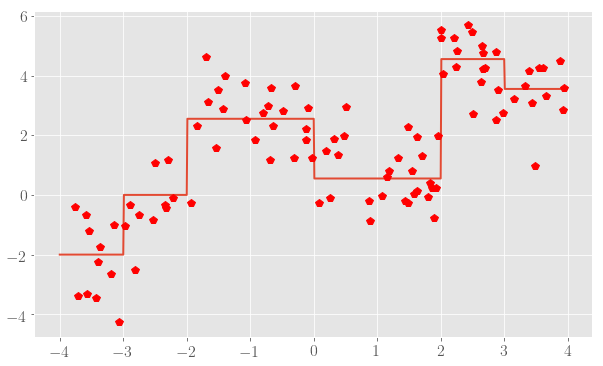

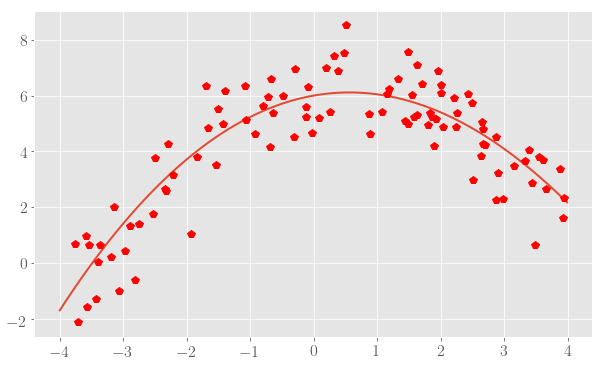

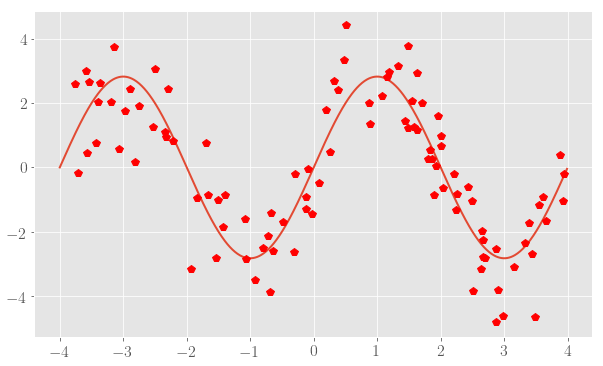

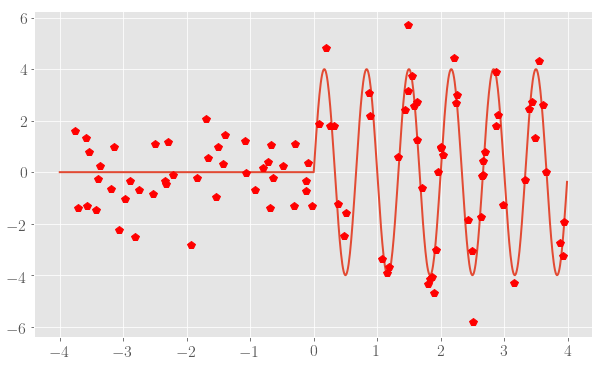

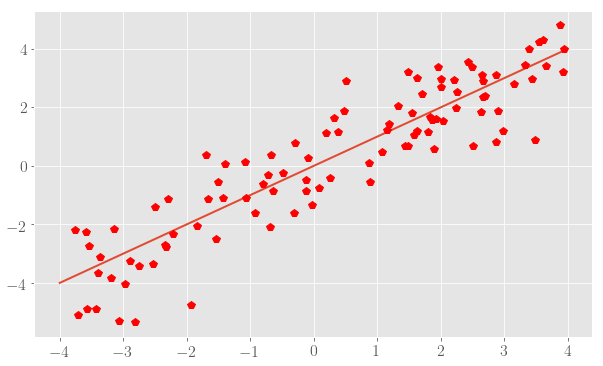

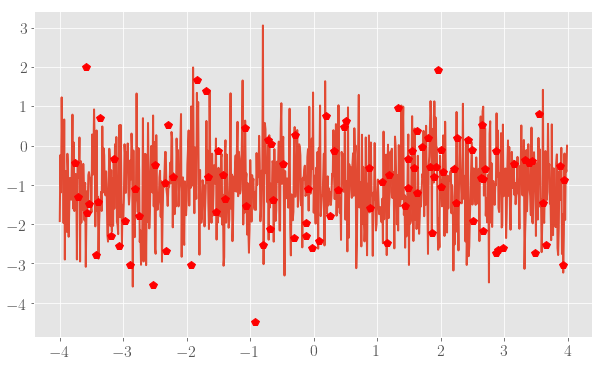

In [16]:
x = np.random.uniform(-4, 4, 100) 
t = np.arange(-4.0, 4.0, 0.01)
err = np.random.normal(0, 1, 100)
for func in function_list:
    yt = func(t)
    yerr = func(x) + err
    plt.plot(t, yt, x, yerr, 'rp')
    plt.show()


In [17]:
x = np.random.uniform(-4, 4, 100) 
t = np.arange(-4.0, 4.0, 0.01)

data = list()
err = np.random.normal(0, 1, 100)
for func in function_list:  
    yt = func(t)
    yerr = func(x) + err
    data.append([x, yerr])
data = np.array(data)


In [18]:
print(data.shape)

(6, 2, 100)


In [19]:
n_folds =  5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1993).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
             

This model may be very sensitive to outliters. So wee need to make it more robost on them.
we use for that sklearns Robustscaler() method on pipleine

In [20]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))


#### Elastic Net Regression:

In [21]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### Kernel Ridge Regression

In [22]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial',degree=2, coef0=2.5)

Gradient Boosting Regression
with huber loss that makes it robutst to outlies

In [23]:
GBoost = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features='sqrt',min_samples_leaf=15,min_samples_split=10,loss='huber',random_state=5)

# Average Base model

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)


In [96]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)



Try out Some Models

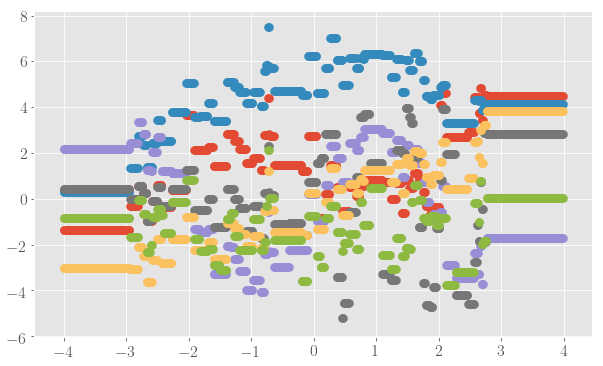

In [73]:
def train_and_plot_predictions(model):
    for e in data:
        model.fit(e[0].reshape(-1, 1), e[1])
        t = np.arange(-4.0, 4.0, 0.01)
        y_pred = model.predict(t.reshape(-1, 1))
        plt.scatter(t.reshape(-1, 1), y_pred)

train_and_plot_predictions(KRR)


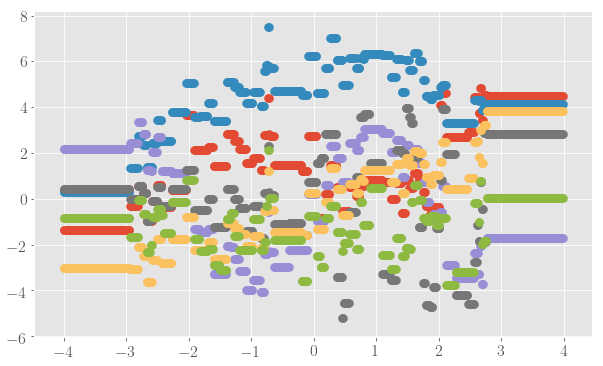

In [74]:
train_and_plot_predictions(GBoost)

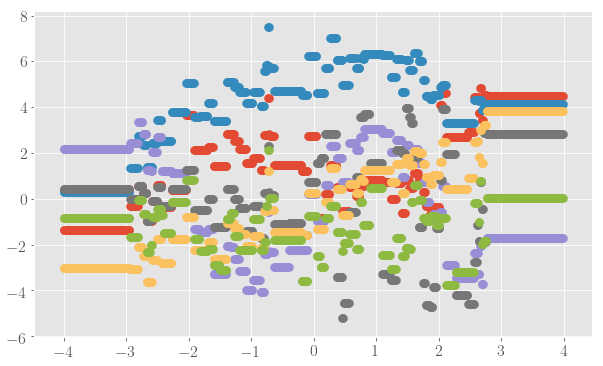

In [76]:
train_and_plot_predictions(GBoost)


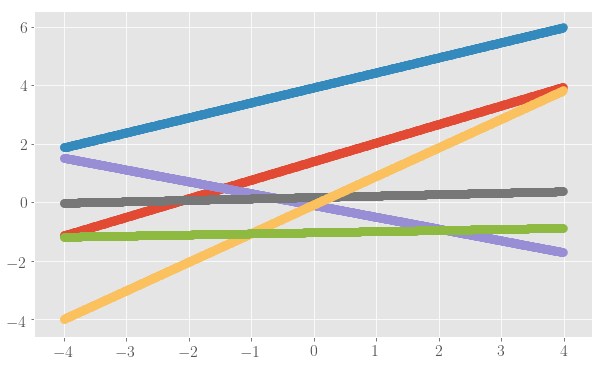

In [78]:
train_and_plot_predictions(ENet)

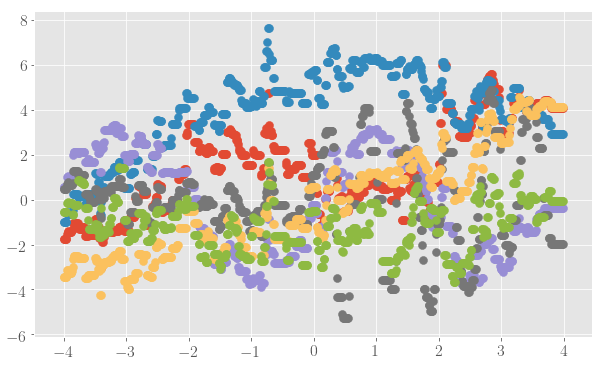

In [87]:
train_and_plot_predictions(RandomForestRegressor())


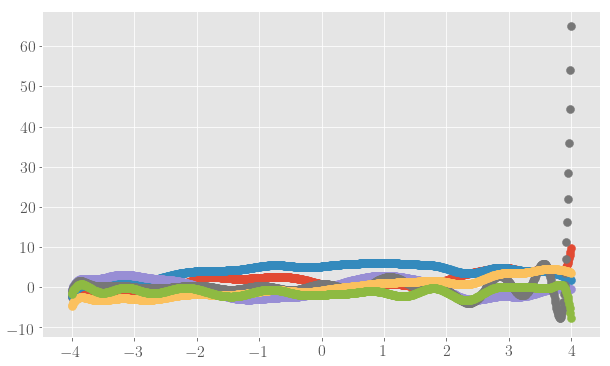

In [90]:
train_and_plot_predictions(GaussianProcessRegressor())

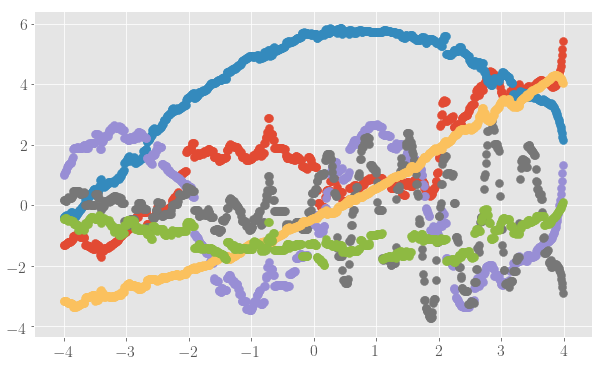

In [99]:
train_and_plot_predictions(AveragingModels(models=(GaussianProcessRegressor(),RandomForestRegressor(),ENet,GBoost,KRR)))


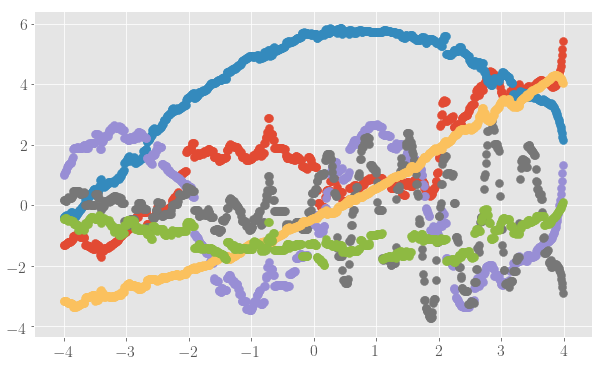

In [110]:

train_and_plot_predictions(StackingAveragedModels(base_models=(GaussianProcessRegressor(),RandomForestRegressor(),ENet,GBoost,KRR),meta_model=(LinearRegression())))
